# Ligand-only experiment

In this notebook we will run an experiment using KinoML. In this case we will focus on ligands that have affinity for the kinase EGFR. To run this experiments we will use `kinoml.features.ligand.OneHotSMILESFeaturizer`, which means that we will only use ligand information to train our model and run our experiments. This notebook is divided into two parts, the first part is about featurizing the dataset and the second part is the actual experiment.

## 1. Featurize the dataset

Any machine learning model will expect tensorial representations of the chemical data. This notebooks provides a workflow to achieve such goal.

`kinoml.dataset.DatasetProvider` objects need to be available to deal with your collection of raw measurements for protein:ligand systems. These objects are, roughly, a list of `kinoml.core.BaseMeasurement`, each containing a set of `.values` and a some extra metadata, like the `system` objects to be featurized here.

In ligand-based models, protein information is only considered marginally, and most of the action happens at the ligand level. Usually starting with a string representation such as SMILES, or a database identifier such as a PubChem ID, these are promoted to (usually) RDKit objects and then transformed into a tensor of some form (e.g. fingerprints, molecular graph as an adjacency matrix, etc).

Available featurizers can be found under `kinoml.features`.

In [1]:
# If this is the template file (and not a copy) and you are introducing changes,
# update VERSION with the current date (YYYY.MM.DD)
VERSION = "2023.11.06" 

In [2]:
#fuction to obtain current working path to ouput results
def main():
    parameters["HERE"] = str(nbout.parent.resolve())

In [3]:
HERE = _dh[-1] #current path

## ✏ Define hyper parameters

Now we will define the parameters of our featurization pipeline. Note that you can adapt these parameters to your data and any experiments you want to run. If you use a different dataset, please make sure it is processed (e.g. no empty values, repeated entries, etc...)

In [4]:
# Parameters
DATASET_CLS = "kinoml.datasets.chembl.ChEMBLDatasetProvider"
DATASET_KWARGS = {
    "path_or_url": "../data/filtered_dataset_EGFR.csv", #your dataset
    "measurement_types": ["pIC50", "pKd", "pKi"], #the type of measurements you are interested in
    "uniprot_ids": ["P00533"], #the kinase
    "sample": 1000, #number of samples you want to work with, to run the notebook faster you can pick a smaller number
}
DATASET_KWARGS = {
    "path_or_url": "../data/filtered_dataset_EGFR.csv",
    "sample": 1000,
}
PIPELINES = {
    "ligand": [
        ["kinoml.features.ligand.OneHotSMILESFeaturizer", {}],
        ["kinoml.features.core.PadFeaturizer", {"shape": "auto"}],
    ]
}
PIPELINES_AGG = "kinoml.features.core.TupleOfArrays"
PIPELINES_AGG_KWARGS = {}
FEATURIZE_KWARGS = {"keep": False}
GROUPS = [
    [
        "kinoml.datasets.groups.CallableGrouper",
        {"function": "lambda measurement: measurement.system.protein.name"},
    ],
    [
        "kinoml.datasets.groups.CallableGrouper",
        {"function": "lambda measurement: type(measurement).__name__"},
    ],
]
TRAIN_TEST_VAL_KWARGS = {"idx_train": 0.8, "idx_test": 0.1, "idx_val": 0.1}

⚠ If you are adapting this notebook to your own dataset, you should _not_ need to modify anything from here 🤞

---

Define key paths for data and outputs:

In [5]:
from pathlib import Path

HERE = Path(HERE)
for parent in HERE.parents:
    if next(parent.glob(".github/"), None):
        REPO = parent
        break

# Generate paths for this pipeline
featurizer_path = []
for name, branch in PIPELINES.items():
    featurizer_path.append(name)
    for clsname, kwargs in branch:
        clsname = clsname.rsplit(".", 1)[1]
        kwargs = [f"{k}={''.join(c for c in str(v) if c.isalnum())}" for k,v in kwargs.items()]
        featurizer_path.append("_".join([clsname] + kwargs))

OUT = HERE / "_output"  / "__".join(featurizer_path) / DATASET_CLS.rsplit('.', 1)[1]
OUT.mkdir(parents=True, exist_ok=True)

print(f"This notebook:           HERE = {HERE}")
print(f"This repo:               REPO = {REPO}")
print(f"Outputs in:               OUT = {OUT}")

This notebook:           HERE = /home/raquellrdc/Desktop/postdoc/kinoml_tech_paper_final/kinoml/examples/experiments/ligand-only-smiles-EGFR
This repo:               REPO = /home/raquellrdc/Desktop/postdoc/kinoml_tech_paper_final/kinoml
Outputs in:               OUT = /home/raquellrdc/Desktop/postdoc/kinoml_tech_paper_final/kinoml/examples/experiments/ligand-only-smiles-EGFR/_output/ligand__OneHotSMILESFeaturizer__PadFeaturizer_shape=auto/ChEMBLDatasetProvider


In [6]:
# Nasty trick: save all-caps local variables (CONSTANTS working as hyperparametrs) so far in a dict to save it later
_hparams = {key: value for key, value in locals().items() if key.upper() == key and not key.startswith(("_", "OE_"))}

## Setup is finished, start working

In [7]:
from warnings import warn
import os
import sys
from pathlib import Path
from datetime import datetime

import numpy as np
import awkward as ak

from kinoml.utils import seed_everything, import_object
seed_everything();
print("Run started at", datetime.now())

Run started at 2023-11-06 10:15:13.189152


## Load raw data

> This `import_object` function allows us to take a `str` containing a Python import path (e.g. `kinoml.datasets.chembl.ChEMBLDatasetProvider`) and obtain the imported object directly. That's how we can encode classes in JSON-only `papermill` inputs.
>
> See the help message `import_object?` for more info.
Note that you need an OE license

In [8]:

dataset = import_object(DATASET_CLS).from_source(**DATASET_KWARGS)
dataset

/home/raquellrdc/anaconda3/envs/kinoml_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


  0%|          | 0/1000 [00:00<?, ?it/s]

<ChEMBLDatasetProvider with 1000 measurements (pIC50Measurement=947, pKdMeasurement=20, pKiMeasurement=33), and 1000 systems (KLIFSKinase=1, Ligand=1000)>

In [9]:
#visualise your dataset!

df = dataset.to_dataframe()
df

,Systems,n_components,Measurement,MeasurementType
0,P00533 & CC(=O)c1ccccc1-n1c(-c2ccccc2)nc2cc(Cl...,2,6.142668,pIC50Measurement
1,P00533 & COc1cc(C=O)ccc1-c1cc2c(NCc3ccccc3)ncn...,2,8.221849,pIC50Measurement
2,P00533 & O=C(CCN1CCCCC1)Nc1ccc2ncnc(Nc3cccc(Br...,2,9.568636,pIC50Measurement
3,P00533 & C=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc...,2,8.397940,pIC50Measurement
4,P00533 & N#Cc1cnc(Nc2cccc(Br)c2)c2cc(NC(=O)CCN...,2,5.161151,pIC50Measurement
...,...,...,...,...
995,P00533 & N#CC(C#N)=Cc1cc(O)cc(O)c1,2,5.000000,pKiMeasurement
996,P00533 & CN(C)c1ccc(/C=C(\C#N)C(=O)O)cc1,2,2.853872,pKiMeasurement
997,P00533 & N#CC(C#N)=Cc1ccc(O)cc1,2,3.795880,pKiMeasurement
998,P00533 & COC1CCN(c2nccc(Nc3cc4c(C(C)C)n[nH]c4c...,2,7.744727,pKiMeasurement


## Featurize

Now, let's convert the data set into somehting that is ML-readable!

In [10]:
# build pipeline
from kinoml.features.core import Pipeline

pipelines = []
for key, pipeline_instructions in PIPELINES.items():
    print(f"Building featurizer `{key}` with instructions:")
    featurizers = []
    for featurizer_import_str, kwargs in pipeline_instructions:
        kwargs = kwargs or {}  # make sure empty values (None, "") turn into {} so we can do **kwargs below
        print(f"  Instantiating `{featurizer_import_str}` with options `{kwargs}`")
        featurizers.append(import_object(featurizer_import_str)(**kwargs))
    pipelines.append(Pipeline(featurizers))
print("Resulting pipelines:", *pipelines)
aggregated_pipeline = import_object(PIPELINES_AGG)(pipelines, **PIPELINES_AGG_KWARGS)
print("Aggregated pipelines:", aggregated_pipeline)

Building featurizer `ligand` with instructions:
  Instantiating `kinoml.features.ligand.OneHotSMILESFeaturizer` with options `{}`
  Instantiating `kinoml.features.core.PadFeaturizer` with options `{'shape': 'auto'}`
Resulting pipelines: <Pipeline([OneHotSMILESFeaturizer, PadFeaturizer])>
Aggregated pipelines: <TupleOfArrays([Pipeline([OneHotSMILESFeaturizer, PadFeaturizer])])>


In [11]:
%%capture --no-display
# to hide warnings

aggregated_pipeline.featurize(dataset.systems, **FEATURIZE_KWARGS);

[<ProteinLigandComplex with 2 components (<KLIFSKinase name=P00533>, <Ligand name=COc1cccc(Nc2cc(Nc3ccc(S(N)(=O)=O)cc3)ncn2)c1>)>,
 <ProteinLigandComplex with 2 components (<KLIFSKinase name=P00533>, <Ligand name=Cn1cnc(-c2ccc(OC(F)(F)F)c(NC(=O)Nc3ccncc3)c2)c1>)>,
 <ProteinLigandComplex with 2 components (<KLIFSKinase name=P00533>, <Ligand name=c1ccc(CCNc2ncnc3ccccc23)cc1>)>,
 <ProteinLigandComplex with 2 components (<KLIFSKinase name=P00533>, <Ligand name=COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCCC1>)>,
 <ProteinLigandComplex with 2 components (<KLIFSKinase name=P00533>, <Ligand name=COc1cc(N2CCC(O)CC2)ccc1Nc1ncc(Cl)c(Oc2cccc(COc3no[n+]([O-])c3S(=O)(=O)c3ccccc3)c2)n1>)>,
 <ProteinLigandComplex with 2 components (<KLIFSKinase name=P00533>, <Ligand name=Nc1nc(Nc2ccc(Cl)cc2F)c2cc(CCc3ccccc3)[nH]c2n1>)>,
 <ProteinLigandComplex with 2 components (<KLIFSKinase name=P00533>, <Ligand name=CN(CCN/N=N/c1ccc2ncnc(Nc3cccc(Cl)c3)c2c1)CCNS(=O)(=O)c1cccc2c(N(C)C)cccc12>)>,
 <ProteinLigandComplex wi

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 24, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 26, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 57, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 20, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 28, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 42, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 17, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 33, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 17, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 32, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 25, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 24, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 26, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 27, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 39, aromatic: False, chiral: False
Atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 52, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 51, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 59, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 53, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 109, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 6, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 17, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 28, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 33, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 36, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 22, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 32, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 32, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 33, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 13, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 15, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 49, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 32, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 33, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 15, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 17, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 19, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 36, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 32, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 33, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 19, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 13, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 20, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 46, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 57, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 10, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 9, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 30, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 12, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 10, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 13, aromatic: True, chiral: False
bond ord

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 13, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 53, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 22, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 53, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 9, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 15, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 28, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 6, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 27, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 1, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 33, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 37, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 24, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 26, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 57, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 33, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 38, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False
bond 

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: True, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 24, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 26, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 59, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 10, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 9, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 24, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 44, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 13, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 45, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 22, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 24, aromatic: False, chiral: False
bond o

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 15, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 17, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 19, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 35, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 33, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 35, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 9, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 10, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 27, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 26, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 36, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 28, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 48, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 29, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 28, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 30, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: False, chiral: True
bond o

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 27, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 26, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 28, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 18, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 29, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 9, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 28, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 22, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 30, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 13, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 22, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 44, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 13, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 22, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 31, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 30, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 33, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 33, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic bonds are: [<openeye.oechem.OEBondBase; proxy of <Swig Object of type 'OEChem::OEBondBase *' at 0x7f81a718b1b0> >, <openeye.oechem.OEBondBase; proxy of <Swig Object of type 'OEChem::OEBondBase *' at 0x7f81a718ba20> >]



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 32, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 33, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 36, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 27, aromatic: False, chiral: True



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 16, name: , idx: 30, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 31, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 23, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 25, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 24, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 36, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 26, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 31, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 30, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 33, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic bonds are: [<openeye.oechem.OEBondBase; proxy of <Swig Object of type 'OEChem::OEBondBase *' at 0x7f81a7219e40> >, <openeye.oechem.OEBondBase; proxy of <Swig Object of type 'OEChem::OEBondBase *' at 0x7f81a7219510> >, <openeye.oechem.OEBondBase; proxy of <Swig Object of type 'OEChem::OEBondBase *' at 0x7f81a72194b0> >, <openeye.oechem.OEBondBase; proxy of <Swig Object of type 'OEChem::OEBondBase *' at 0x7f81a7219d80> >]



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 20, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 19, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 22, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 19, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 20, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 27, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 38, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 22, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 55, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic bonds are: [<openeye.oechem.OEBondBase; proxy of <Swig Object of type 'OEChem::OEBondBase *' at 0x7f81a71e6cc0> >]



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 30, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 20, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 28, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 42, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 16, name: , idx: 13, aromatic: False, chiral: True with bonds:
bond order: 2, chiral: False to atom atomic num: 7, name: , idx: 12, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: True, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 33, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 33, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 44, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 18, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 37, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 17, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 32, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 17, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 31, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 30, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 36, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 23, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 59, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 35, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 18, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 17, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 35, name: , idx: 19, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 20, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 33, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 10, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 11, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 54, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 27, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 26, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 28, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: False, chiral: False
bond 

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 13, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 12, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 35, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 22, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 52, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 22, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 24, aromatic: False, chiral: False
bond order

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 15, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 29, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 30, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 8, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 9, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 28, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 35, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 16, name: , idx: 22, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 24, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 5, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: True, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 16, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 17, aromatic: True, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 23, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 22, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 30, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 24, aromatic: False, chiral: False
Atom atomic num: 7, name: , idx: 27, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 26, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 28, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 30, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 28, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 27, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 16, name: , idx: 32, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 48, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 20, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 19, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 26, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 18, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 35, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 16, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 15, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 0, aromatic: False, chiral: False
bond order: 2, chiral: False to atom atomic num: 8, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 27, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 33, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 35, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 13, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 44, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 16, name: , idx: 2, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: True, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 36, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 35, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 37, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 38, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 32, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 33, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 6, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 10, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 30, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 22, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 28, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 19, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 20, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 27, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 42, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 37, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 36, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 38, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 39, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 25, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 24, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 26, aromatic: False, chiral: False
Atom atomic num: 7, name: , idx: 28, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 27, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 30, aromatic: False, chiral: True
Atom atomic num: 6, name: , idx: 30, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: Fals

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 30, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 17, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 32, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 9, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 10, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 41, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 13, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 12, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 36, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 10, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 35, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 30, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 20, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 28, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 42, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 24, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 26, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 58, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 30, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 37, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 45, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 36, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 35, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 42, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 37, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 40, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 39, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 41, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 42, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 69, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 13, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 16, name: , idx: 17, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 44, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 16, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 42, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 9, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 31, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 9, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 5, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 42, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 56, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 20, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 19, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: False
bond or

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 32, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 33, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 26, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 25, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 27, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 58, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 22, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 24, aromatic: False, chiral: True



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 16, name: , idx: 25, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 22, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 36, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 9, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 10, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 41, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 16, name: , idx: 14, aromatic: False, chiral: True with bonds:
bond order: 2, chiral: False to atom atomic num: 7, name: , idx: 13, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: True, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 27, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 31, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 30, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 33, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 30, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 9, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 10, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 36, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 6, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 27, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic bonds are: [<openeye.oechem.OEBondBase; proxy of <Swig Object of type 'OEChem::OEBondBase *' at 0x7f823cfe34e0> >]



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 9, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 10, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 36, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 10, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 50, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 29, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 28, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 30, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 35, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 25, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 24, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 26, aromatic: False, chiral: False
Atom atomic num: 7, name: , idx: 29, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 28, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 30, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 24, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 26, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 27, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 60, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 29, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 27, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 30, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: False, chiral: False
bond

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 8, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 9, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 9, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 17, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 42, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 8, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 9, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 30, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 22, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 24, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 22, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 42, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 20, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 22, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 43, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 10, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 9, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 11, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 17, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 39, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 19, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 20, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 30, aromatic: False, chiral: False
bond ord

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 5, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 17, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 18, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 47, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 33, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 35, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 28, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 27, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 30, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 24, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 32, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 33, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 17, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 36, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 10, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 16, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 16, name: , idx: 12, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 52, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 20, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 19, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 9, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 40, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 20, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 31, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 36, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 35, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 16, name: , idx: 40, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 37, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 62, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 9, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 47, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 30, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 13, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 55, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic bonds are: [<openeye.oechem.OEBondBase; proxy of <Swig Object of type 'OEChem::OEBondBase *' at 0x7f823cf485a0> >]



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 37, aromatic: False, chiral: False
Atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 10, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 9, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 15, aromatic: False, chiral: False
Problematic bonds are: [<openeye.oechem.OEBondBase; proxy of <Swig Object of type 'OEChem::OEBondBase *' at 0x7f823cee94b0> >]



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 52, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 51, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 58, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 53, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 108, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 33, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 35, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 28, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 27, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 30, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 5, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 13, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 33, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 33, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 35, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 10, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 25, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 43, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 39, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 8, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 9, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 30, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 8, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 9, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 10, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 18, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 17, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 27, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 19, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 54, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 20, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 19, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: True
bond o

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 6, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 24, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 26, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 58, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 22, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 42, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 16, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 33, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 22, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 24, aromatic: False, chiral: True



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 5, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 13, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 33, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 10, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 16, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 16, name: , idx: 12, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 53, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 37, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 17, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 47, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 20, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 19, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 37, aromatic: False, chiral: False
bond

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 6, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 36, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 10, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 36, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 38, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 22, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 26, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 42, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 15, name: , idx: 22, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 23, aromatic: False, chiral: False
bond order: 2, chiral: False to atom atomic num: 8, name: , idx: 24, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 25, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 9, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 29, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 24, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 59, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 33, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 20, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 43, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 6, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 25, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 18, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 29, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 30, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 12, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 13, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 33, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 18, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 17, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 27, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 19, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 13, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 33, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: True, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 20, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 28, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 42, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 16, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 30, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 33, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 9, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 49, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 22, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 32, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 19, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 18, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 20, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 22, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 42, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 27, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 26, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 28, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: True, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 13, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 44, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 44, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 13, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 26, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 10, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 34, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 15, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 0, aromatic: False, chiral: False
bond order: 2, chiral: False to atom atomic num: 8, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 36, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 33, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 32, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 32, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 33, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 19, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 13, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 20, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 45, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 6, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 28, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 15, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 0, aromatic: False, chiral: False
bond order: 2, chiral: False to atom atomic num: 8, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 26, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 17, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 33, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 17, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 16, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 18, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 31, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 5, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 13, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 30, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 34, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 33, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 35, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 36, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 37, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 9, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: False, chiral: False
bond order

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 10, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 9, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 11, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 17, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 39, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 19, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 20, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 30, aromatic: False, chiral: False
bond ord

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 13, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 22, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 2, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 41, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 24, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 26, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 31, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 39, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 27, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: False
bond order: 1

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 16, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 30, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 5, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 26, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 9, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 26, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 36, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 28, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 27, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 30, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 17, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 18, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 39, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 30, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 16, name: , idx: 31, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 30, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 33, aromatic: False, chiral: False
Atom atomic num: 16, name: , idx: 60, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 59, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 61, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 62, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 22, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 26, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 22, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 24, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 43, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 34, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 33, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 41, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 35, aromatic: False, chiral: False
Atom atomic num: 7, name: , idx: 38, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 37, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 39, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 40, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 37, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: True, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 31, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 30, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 33, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 28, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 27, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 30, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 27, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 17, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 16, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 18, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 31, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 31, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 18, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 32, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 33, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 9, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 10, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 35, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 16, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 33, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 22, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 42, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 10, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 9, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 37, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 16, name: , idx: 31, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 30, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 33, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 6, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 38, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 13, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 22, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 19, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 20, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 44, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 33, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 24, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 60, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 10, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 9, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 35, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 12, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 10, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 13, aromatic: True, chiral: False
bond ord

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 22, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 39, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 5, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: True, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 33, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 35, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 22, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 30, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 43, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 35, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 36, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 37, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 10, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 9, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 38, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 16, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 34, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 5, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 1, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 44, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 13, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 30, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 15, name: , idx: 26, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 25, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 27, aromatic: False, chiral: False
bond order: 2, chiral: False to atom atomic num: 8, name: , idx: 28, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 29, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 32, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 33, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 72, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 30, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 35, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 32, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 33, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 18, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 29, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 36, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 13, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 33, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 32, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 39, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 33, aromatic: False, chiral: False
Atom atomic num: 7, name: , idx: 35, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 36, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 37, aromatic: False, chiral: True
Atom atomic num: 6, name: , idx: 37, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: Fals

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 34, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 32, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 33, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 13, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 22, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 56, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 16, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 22, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 24, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 22, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 26, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 45, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 22, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 32, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 20, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 19, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 20, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 28, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 42, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 1, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 35, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 39, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 34, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 36, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 42, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 55, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 20, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 19, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: False
bond or

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 35, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 5, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 16, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 9, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 13, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 45, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 22, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 24, aromatic: False, chiral: False
bond o

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 33, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 35, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 13, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 47, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 27, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False
bond order

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 5, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: True



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 10, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 31, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 23, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 9, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 20, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 10, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 36, aromatic: False, chiral: False
Atom atomic num: 7, name: , idx: 12, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 13, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 20, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 22, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 54, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 17, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 28, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 10, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 9, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 16, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 17, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 18, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 21, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 36, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 31, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 30, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 38, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 12, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 13, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 33, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 32, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 22, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 54, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 35, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 1, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 39, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 43, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic bonds are: [<openeye.oechem.OEBondBase; proxy of <Swig Object of type 'OEChem::OEBondBase *' at 0x7f823cc5bc00> >, <openeye.oechem.OEBondBase; proxy of <Swig Object of type 'OEChem::OEBondBase *' at 0x7f823cc5bcc0> >]



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic bonds are: [<openeye.oechem.OEBondBase; proxy of <Swig Object of type 'OEChem::OEBondBase *' at 0x7f823cbb9d20> >]



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 33, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 35, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 23, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 33, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 35, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: True, chiral: False
Atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 30, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 13, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 22, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 56, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic bonds are: [<openeye.oechem.OEBondBase; proxy of <Swig Object of type 'OEChem::OEBondBase *' at 0x7f823ccc3b10> >]



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 24, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 52, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 17, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 33, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 34, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 33, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 35, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 36, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 32, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 34, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 35, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 27, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 32, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 33, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 19, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 30, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 31, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 30, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 33, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 34, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 33, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 35, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 36, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 22, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 42, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 30, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 9, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 10, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 34, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 34, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 33, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 35, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 36, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 18, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 38, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 10, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 9, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 29, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 12, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 10, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 13, aromatic: True, chiral: False
bond ord

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 5, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 17, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 33, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 33, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 35, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 36, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 35, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 37, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 38, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 13, aromatic: True, chiral: False
Atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 36, aromatic: False, chiral: False
Atom atomic n

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic bonds are: [<openeye.oechem.OEBondBase; proxy of <Swig Object of type 'OEChem::OEBondBase *' at 0x7f823c85be70> >]



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 22, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 53, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 34, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 30, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 28, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 36, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 17, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 28, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 26, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 36, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 17, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 26, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 18, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 24, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 37, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 33, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 35, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 16, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 17, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 26, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 10, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 27, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 56, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 22, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 28, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False
Atom atomic num: 7, name: , idx: 25, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 24, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 26, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 27, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 28, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: Fal

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: True, chiral: False
Atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 30, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 33, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 35, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 10, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 16, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 16, name: , idx: 12, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 54, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 27, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 26, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 28, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 52, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 17, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 33, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 30, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 19, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 18, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 20, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 49, aromatic: False, chiral: False
Atom atomic num: 7, name: , idx: 23, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 22, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 24, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 19, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 30, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 13, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 28, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 43, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 6, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 10, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 31, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 30, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 15, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 20, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 17, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 30, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 30, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 16, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 30, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 19, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 20, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 27, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 42, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 26, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 24, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 26, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 57, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 16, name: , idx: 1, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 33, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 35, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 8, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 9, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 34, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 33, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 35, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 36, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 24, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 49, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 6, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 38, aromatic: False, chiral: False
Atom atomic num: 7, name: , idx: 6, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 13, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 18, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 51, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 26, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 27, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 28, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 45, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 24, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 23, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 33, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 25, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 59, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 26, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 25, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 27, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: False, chiral: True
bond o

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 22, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 24, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 45, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 18, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 17, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 13, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 19, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic bonds are: [<openeye.oechem.OEBondBase; proxy of <Swig Object of type 'OEChem::OEBondBase *' at 0x7f823cabdea0> >]



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 19, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 30, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 13, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 17, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 18, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 2, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 22, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 54, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 30, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 30, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 22, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 41, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 5, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 16, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 28, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 8, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 9, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 32, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 33, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 22, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 24, aromatic: False, chiral: True



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 9, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 54, aromatic: False, chiral: False
Atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 9, aromatic: False, chiral: True



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 15, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 17, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 18, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 36, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 36, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 10, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 32, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 41, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 33, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 35, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 34, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 40, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 36, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 41, aromatic: False, chiral: False
Atom 

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 13, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 33, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 27, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 26, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 28, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 36, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 22, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 28, aromatic: False, chiral: True



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 13, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 38, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 24, aromatic: False, chiral: False



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 22, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 50, aromatic: False, chiral: False



## Filter

Remove systems that couldn't be featurized. Successful featurizations are stored in `measurement.system.featurizations['last']` so we test for that key existence.

In [12]:
from kinoml.datasets.groups import CallableGrouper, RandomGrouper
grouper = CallableGrouper(lambda measurement: 'invalid' if 'last' not in measurement.system.featurizations else 'valid')
grouper.assign(dataset, overwrite=True, progress=False)
groups = dataset.split_by_groups()
if "invalid" in groups:
    _invalid = groups.pop("invalid")
    warn(f"{len(_invalid)} entries could not be featurized!. Possible errors:")
    warn(f"{_invalid[0].system.featurizations}")

## Groups

Cumulatively apply groups.

In [13]:
groups[("valid",)] = groups.pop("valid")
if GROUPS:
    for grouper_str, grouper_kwargs in GROUPS:
        grouper_cls = import_object(grouper_str)
        ## We need this because lambda functions are not JSON-serializable
        if issubclass(grouper_cls, CallableGrouper):
            for k, v in list(grouper_kwargs.items()):
                if k == "function" and isinstance(v, str):
                    grouper_kwargs[k] = eval(v)  # sorry :)
        ## End of lambda hack
        grouper = grouper_cls(**grouper_kwargs)        
        for group_key in list(groups.keys()):
            grouper.assign(groups[group_key], overwrite=True, progress=False)
            for subkey, subgroup in groups.pop(group_key).split_by_groups().items():
                groups[group_key + (subkey,)] = subgroup
print("10 groups to show keys:", *list(groups.keys())[:10], sep="\n")

10 groups to show keys:
('valid', 'P00533', 'pIC50Measurement')
('valid', 'P00533', 'pKdMeasurement')
('valid', 'P00533', 'pKiMeasurement')


## Write tensors to disk

Output files are written to `_output/<PIPELINE>/<DATASET>/<GROUP>.parquet` files.

Each `parquet` will contain at least two array-like objects. The dimensionality of the parquet files is built as `(systems, X_or_y, ...)`. For example, the first X vector for the first system is accessed like `parquet[0, "0"]`. Notice how the 2nd index is a string! (`awkward` design).

- `"0"` (X, featurized systems). See `DatasetProvider.to_awkward` for more info.
- `"1"` (y, associated measurements)

If `X` is composed of more than one array (e.g. connectivity matrix + node features), these are flattened to `"0"`, `"1"`, `"2"`, and so on. `y` is ALWAYS the last one in that list (accessible via `data.fields`)

In [14]:
random_grouper = RandomGrouper(TRAIN_TEST_VAL_KWARGS)

parquets = []
for group, ds in sorted(groups.items(), key=lambda kv: len(kv[1]), reverse=True):
    indices = random_grouper.indices(ds)
    X, y = ds.to_awkward()
    parquet = ak.zip([*X, y], depth_limit=1)
    path = OUT / f"{'__'.join([g for g in group if g != 'valid'])}.parquet"
    parquets.append(path)
    ak.to_parquet(parquet, path)
    # TODO: Missing indices?

Preview generated Parquet files:

In [15]:
from kinoml.datasets.torch_datasets import AwkwardArrayDataset
awk = AwkwardArrayDataset.from_parquet(parquets[0])
awk

<Array [([[...], ...], 6.14), ..., (..., ...)] type='947 * (var * var * flo...'>

In [16]:
# X, y = awk[0]  # (multi-X) and y tensors for first system

In [17]:
# X

In [18]:
# y

In [19]:
print("Run finished at", datetime.now())

Run finished at 2023-11-06 10:15:40.593058


# Reproducibility logs

In [20]:
# Free some memory first
del awk, parquets, groups, dataset

In [21]:
from kinoml.utils import watermark
w = watermark()

Watermark
---------
Last updated: 2023-11-06T10:15:40.605328+01:00

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.15.0

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 6.2.0-36-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 16
Architecture: 64bit

Hostname: aleph

Git hash: d2352d6e07d594ed9fd973b544529f89feb82d78

sys    : 3.9.18 | packaged by conda-forge | (main, Aug 30 2023, 03:49:32) 
[GCC 12.3.0]
numpy  : 1.26.0
awkward: 2.4.6

Watermark: 2.4.3


nvidia-smi
----------
stdout:
Mon Nov  6 10:15:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|             

In [22]:
%%capture cap --no-stderr
w = watermark()

In [23]:
import json

with open(OUT/ "watermark.txt", "w") as f:
    f.write(cap.stdout)

with open(OUT / "hparams.json", "w") as f:
    json.dump(_hparams, f, default=str, indent=2)

# 2. Run the experiment



## Train a model with PyTorch

Now, we will train a single model using only PyTorch.

1. Tensors are loaded from Parquet files generated in the `features/` pipeline. Each Parquet becomes a Torch Dataset sublass.
2. Random splits are applied for train/test/(val).
3. It will train a single for model for a number of epochs across all datasets: epoch> dataloader> minibatch.
4. The loss is computed through the `loss_adapter` method in each measurement_type.
5. If validation is enabled, early stopping and LR schedulers are applied.

## Define hyper parameters

In [24]:
# Parameters
PARQUET_LOADER_CLS = "kinoml.datasets.torch_datasets.AwkwardArrayDataset"
PARQUET_FILES = [
    "ligand-only-smiles-EGFR/_output/ligand__OneHotSMILESFeaturizer__PadFeaturizer_shape=auto/ChEMBLDatasetProvider/*.parquet"]

# Model -- specified with the full import path to the class object
## Machine learning model that will be trained. Pass it as importable string.
MODEL_CLS = "kinoml.ml.torch_models.ConvolutionNeuralNetworkRegression"
## Keyword arguments for the model initialization
MODEL_KWARGS = {"hidden_shape": 350}  # input_shape is defined dynamically during training

# OPTIMIZER
## Optimizer class. Pass it as an importable string.
OPTIMIZER = "torch.optim.Adam"
## Keyword arguments for the optimizer
OPTIMIZER_KWARGS = {"lr": 0.001, "eps": 1e-7, "betas": [0.9, 0.999]}

# LOSS FUNCTION
## Loss function class. Pass it as an importable string.
LOSS = "torch.nn.MSELoss"
## Keyword arguments for the loss function, if applicable
LOSS_KWARGS = {}

# TRAINING
## Maximum number of epochs the training will run. In practice it might be less due to early stopping
MAX_EPOCHS = 50
## Enable real-time validation: this will split the test set into two halves: test and validation.
## It will also enable LR scheduling and early stopping, based on the validation loss.
VALIDATION = True
## Options for the builtin early stopper (kinoml.ml.torch_loops.EarlyStopping)
EARLY_STOPPING_KWARGS = {}

# DATALOADER
DATALOADER_CLS = "torch.utils.data.DataLoader"  # you can also use torch_geometric.data.DataLoader
## Minibatch size
BATCH_SIZE = 64
## Proportion of the dataset that will be split into a test set. If VALIDATION=True, 
## this will also cover the validation set. So, 0.2 will mean: 0.8 training, 0.1 test, 0.1 valid.
TRAIN_TEST_SPLIT = 0.2
## Whether to shuffle the indices before splitting
SHUFFLE_SPLITS = True
## Read https://pytorch.org/docs/stable/data.html#dataloader-collate-fn
## IMPORTANT: This will be needed if your X tensors have different shapes across systems!
COLLATE_FN = None

# Plot bootstrapping
## Bootstrapping iterations for the performance plots
N_BOOTSTRAPS = 1
## Proportion of the data that is sampled in each iteration
BOOTSTRAP_SAMPLE_RATIO = 1

# Output
## Enable some extra output, like plots and logging statements.
VERBOSE = False


HERE = _dh[-1] #current path

⚠ From here on, you should _not_ need to modify anything else to apply it to your own dataset 🤞

---

Define key paths for data and outputs:

In [25]:
from pathlib import Path
from datetime import datetime

HERE = Path(HERE)

for parent in HERE.parents:
    if next(parent.glob(".github/"), None):
        REPO = parent
        break

FEATURES_STORE = REPO /"examples"/"experiments"
        
OUT = HERE / "_output" / datetime.now().strftime("%Y%m%d-%H%M%S")
OUT.mkdir(parents=True, exist_ok=True)

print(f"This notebook:           HERE = {HERE}")
print(f"This repo:               REPO = {REPO}")
print(f"Features:      FEATURES_STORE = {FEATURES_STORE}")
print(f"Outputs in:               OUT = {OUT}")

This notebook:           HERE = /home/raquellrdc/Desktop/postdoc/kinoml_tech_paper_final/kinoml/examples/experiments/ligand-only-smiles-EGFR
This repo:               REPO = /home/raquellrdc/Desktop/postdoc/kinoml_tech_paper_final/kinoml
Features:      FEATURES_STORE = /home/raquellrdc/Desktop/postdoc/kinoml_tech_paper_final/kinoml/examples/experiments
Outputs in:               OUT = /home/raquellrdc/Desktop/postdoc/kinoml_tech_paper_final/kinoml/examples/experiments/ligand-only-smiles-EGFR/_output/20231106-101546


In [26]:
# Nasty trick: save all-caps local variables (CONSTANTS working as hyperparameters) so far in a dict to save it later
_hparams = {key: value for key, value in locals().items() if key.upper() == key and not key.startswith(("_", "OE_"))}

In [27]:
from collections import defaultdict
from warnings import warn
import sys
import shutil

from IPython.display import Markdown
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from tqdm.auto import trange, tqdm

from kinoml.ml.torch_loops import LRScheduler, EarlyStopping
from kinoml.utils import seed_everything, import_object
from kinoml.core import measurements as measurement_types
from kinoml.core.measurements import null_observation_model
from kinoml.analysis.metrics import performance
from kinoml.analysis.plots import predicted_vs_observed

# Fix the seed for reproducible random splits -- otherwise we get mixed train/test groups every time, biasing the model evaluation
seed_everything();
print("Run started at", datetime.now())

Run started at 2023-11-06 10:15:47.319083


## Load featurized data and create observation models

We assume this path structure: `$REPO/features/_output/<FEATURIZATION>/<DATASET>/<MEASUREMENT_TYPE>.npz`


In [28]:
DATASETS = []
MEASUREMENT_TYPES = set()
ParquetLoaderCls = import_object(PARQUET_LOADER_CLS)
for glob in PARQUET_FILES:
    print(glob)
    parquets = list(FEATURES_STORE.glob(glob))
    if not parquets:
        warn(f"⚠ Parquet glob `{glob}` did not match any files!")
        continue
        
    for parquet in parquets:
        measurement_type = parquet.stem
        dataset = parquet.parent.name
        
        ds = ParquetLoaderCls.from_parquet(parquet)
        ds.metadata = {
            "dataset": dataset,
            "measurement_type": measurement_type,
        }
        DATASETS.append(ds)
        MEASUREMENT_TYPES.add(measurement_type)

if not DATASETS:
    raise ValueError("Provided `PARQUET_FILES` did not result in any valid datasets!")

ligand-only-smiles-EGFR/_output/ligand__OneHotSMILESFeaturizer__PadFeaturizer_shape=auto/ChEMBLDatasetProvider/*.parquet


Now that we have all the data-dependent objects, we can start with the model-specific definitions.

In [29]:
print(f"Loaded {len(DATASETS)} datasets with a total of {sum(len(d) for d in DATASETS)} measurements.")

Loaded 3 datasets with a total of 1000 measurements.


### Prepare splits and dataloaders

Create train / test / validation subsets. Here we implement a random split, but it can take external indices if needed.

In [30]:
dataloaders = {}
for dataset in DATASETS:
    key = dataset.metadata["measurement_type"]
    
    # Generate random indices in situ
    # If you need to provide indices from another source, 
    # replace this block to provide train_indices, test_indices
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(TRAIN_TEST_SPLIT * dataset_size))
    
    if SHUFFLE_SPLITS :
        np.random.shuffle(indices)
    train_indices, test_indices = indices[split:], indices[split:]
    if VALIDATION:
        split2 = int(np.floor(len(test_indices) / 2))
        test_indices, val_indices = test_indices[:split2], test_indices[split2:]
    # End of indices creation
    
    collate_fn = None
    if COLLATE_FN:
        # IMPORTANT: This will be needed if your X tensors have different shapes across systems!
        # COLLATE_FN can be an import string, or a eval-able lambda
        # Read https://pytorch.org/docs/stable/data.html#dataloader-collate-fn
        try:
            collate_fn = import_object(COLLATE_FN)
        except ImportError:
            collate_fn = eval(COLLATE_FN)
    
    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    dataloaders[key] = {
        "train": import_object(DATALOADER_CLS)(dataset, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=collate_fn),
        "test": import_object(DATALOADER_CLS)(dataset, batch_size=BATCH_SIZE, sampler=test_sampler, collate_fn=collate_fn),
    }
    
    if VALIDATION:
        val_sampler = SubsetRandomSampler(val_indices)
        dataloaders[key]["val"] = import_object(DATALOADER_CLS)(dataset, batch_size=BATCH_SIZE, sampler=val_sampler, collate_fn=collate_fn)

### Training loop

In [31]:
ModelCls = import_object(MODEL_CLS)

# Note that we assume all dataloaders will provide the
# same kind of input shape, so we onlt test on one
if ModelCls.needs_input_shape:
    a_dataloader = dataloaders[next(iter(dataloaders.keys()))]["train"]
    x_sample, _ = next(iter(a_dataloader))
    MODEL_KWARGS["input_shape"] = ModelCls.estimate_input_shape(x_sample)

nn_model = ModelCls(**MODEL_KWARGS)

optimizer = import_object(OPTIMIZER)(nn_model.parameters(), **OPTIMIZER_KWARGS)
loss_function = import_object(LOSS)()

if VALIDATION:
    lr_scheduler = LRScheduler(optimizer)
    early_stopping = EarlyStopping(**EARLY_STOPPING_KWARGS)

train_loss_timeseries = []
val_loss_timeseries = []

range_epochs = trange(MAX_EPOCHS, desc="Epochs")
for epoch in range_epochs:
    train_loss = 0.0
    val_loss = 0.0
    for key, loader in tqdm(dataloaders.items(), desc="Datasets", leave=False):
        try:
            mtype_class = import_object(f"kinoml.core.measurements.{key}")
        except AttributeError: 
            mtype_class = import_object(f"kinoml.core.measurements.{key.split('__')[1]}")
        loss_adapter = mtype_class.loss_adapter(backend="pytorch")
        
        # TRAIN
        nn_model.train()
        for x, y in tqdm(loader["train"], desc="Minibatches", leave=False):
            # Clear gradients
            optimizer.zero_grad()
            # Obtain model prediction given model input
            prediction = nn_model(x)
            # apply observation model
            loss = loss_adapter(prediction.view_as(y), y, loss_function)
            # Pred. must match y shape!    ^^^^^^^^^^
            # Obtain loss for the predicted output
            train_loss += loss.item()
            # Gradients w.r.t. parameters
            loss.backward()
            # Optimize
            optimizer.step()
            
        
        # VALIDATE
        if VALIDATION:
            nn_model.eval()
            with torch.no_grad():
                for x, y in tqdm(loader["val"], desc="Minibatches", leave=False):
                    prediction = nn_model(x).view_as(y)
                    loss = loss_adapter(prediction.view_as(y), y, loss_function)
                    val_loss += loss.item()
                    range_epochs.set_description(f"Epochs (Avg. val. loss={val_loss / (epoch + 1):.2e})")
    
    # LOG LOSSES
    train_loss_timeseries.append(train_loss)
    
    if VALIDATION:
        val_loss_timeseries.append(val_loss)

        # Adjust training if needed
        lr_scheduler(val_loss)
        early_stopping(val_loss)
        if early_stopping.early_stop:
            break

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/12 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/6 [00:00<?, ?it/s]

Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/12 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/6 [00:00<?, ?it/s]

Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/12 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/6 [00:00<?, ?it/s]

Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/12 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/6 [00:00<?, ?it/s]

Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/12 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/6 [00:00<?, ?it/s]

Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/12 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/6 [00:00<?, ?it/s]

Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/12 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/6 [00:00<?, ?it/s]

Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/12 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/6 [00:00<?, ?it/s]

Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/12 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/6 [00:00<?, ?it/s]

Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/12 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/6 [00:00<?, ?it/s]

Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/12 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/6 [00:00<?, ?it/s]

Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/12 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/6 [00:00<?, ?it/s]

Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/12 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/6 [00:00<?, ?it/s]

Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/12 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/6 [00:00<?, ?it/s]

Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/12 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/6 [00:00<?, ?it/s]

INFO: Early stopping counter 1 of 5


Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/12 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/6 [00:00<?, ?it/s]

Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/12 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/6 [00:00<?, ?it/s]

Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/12 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/6 [00:00<?, ?it/s]

Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/12 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/6 [00:00<?, ?it/s]

Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/12 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/6 [00:00<?, ?it/s]

Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/12 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/6 [00:00<?, ?it/s]

Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/12 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/6 [00:00<?, ?it/s]

Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/12 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/6 [00:00<?, ?it/s]

Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/12 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/6 [00:00<?, ?it/s]

Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/12 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/6 [00:00<?, ?it/s]

Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/12 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/6 [00:00<?, ?it/s]

INFO: Early stopping counter 2 of 5


Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/12 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/6 [00:00<?, ?it/s]

Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/12 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/6 [00:00<?, ?it/s]

INFO: Early stopping counter 3 of 5


Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/12 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/6 [00:00<?, ?it/s]

INFO: Early stopping counter 4 of 5


Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/12 [00:00<?, ?it/s]

Minibatches:   0%|          | 0/6 [00:00<?, ?it/s]

INFO: Early stopping counter 5 of 5
INFO: Early stopping


Save model to disk

In [33]:
torch.save(nn_model, OUT / "nn_model.pt")

### Evaluate model

#### P00533__pKiMeasurement

##### train

 MAE: 0.1604±0.0194 95CI=(0.1331, 0.1940)
 MSE: 0.0351±0.0071 95CI=(0.0248, 0.0473)
  R2: 0.9759±0.0147 95CI=(0.9517, 0.9889)
RMSE: 0.1863±0.0188 95CI=(0.1575, 0.2175)


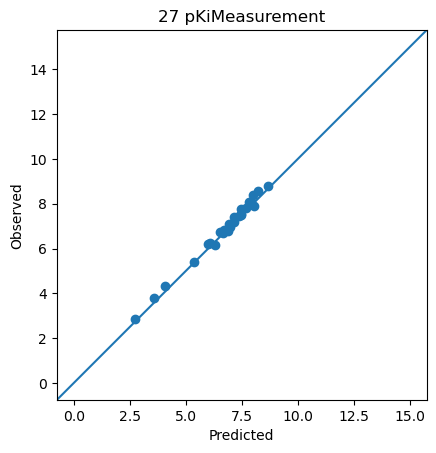

##### test

 MAE: 0.1827±0.0276 95CI=(0.1317, 0.2254)
 MSE: 0.0421±0.0114 95CI=(0.0218, 0.0610)
  R2: 0.9659±0.0406 95CI=(0.8957, 0.9884)
RMSE: 0.2032±0.0285 95CI=(0.1476, 0.2470)


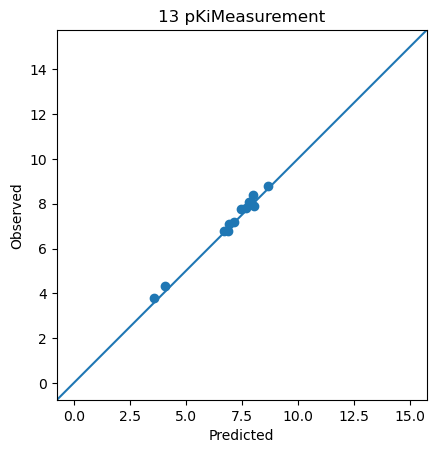

##### val

 MAE: 0.1334±0.0305 95CI=(0.0860, 0.1868)
 MSE: 0.0267±0.0107 95CI=(0.0119, 0.0438)
  R2: 0.9695±0.0289 95CI=(0.9180, 0.9935)
RMSE: 0.1599±0.0329 95CI=(0.1090, 0.2092)


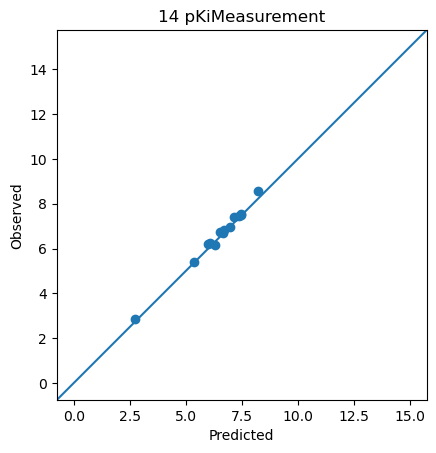

#### P00533__pKdMeasurement

##### train

 MAE: 0.3447±0.1288 95CI=(0.1899, 0.5692)
 MSE: 0.3078±0.2553 95CI=(0.0473, 0.7105)
  R2: 0.7518±0.2481 95CI=(0.2974, 0.9662)
RMSE: 0.5049±0.2301 95CI=(0.2174, 0.8429)


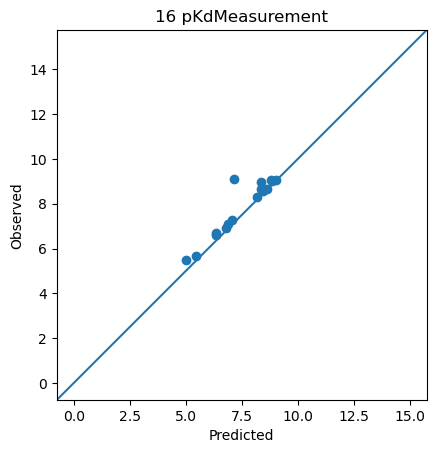

##### test

 MAE: 0.2467±0.0704 95CI=(0.1483, 0.3732)
 MSE: 0.0879±0.0470 95CI=(0.0278, 0.1694)
  R2: 0.7269±0.9792 95CI=(0.6081, 0.9601)
RMSE: 0.2860±0.0784 95CI=(0.1666, 0.4116)


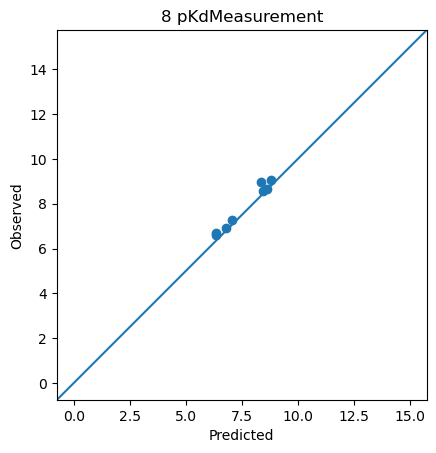

##### val

 MAE: 0.4523±0.2470 95CI=(0.1672, 0.8707)
 MSE: 0.5403±0.5099 95CI=(0.0346, 1.3158)
  R2: -53.9573±538.8569 95CI=(-0.8780, 0.9748)
RMSE: 0.6364±0.3677 95CI=(0.1859, 1.1471)


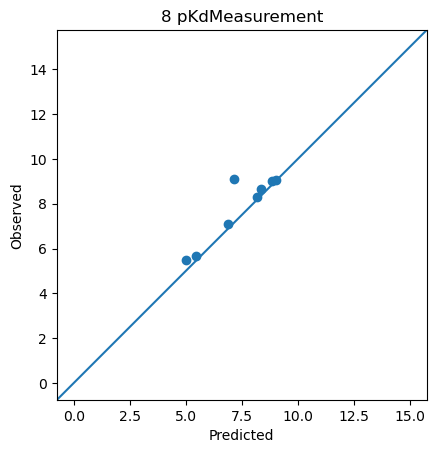

#### P00533__pIC50Measurement

##### train

 MAE: 0.1833±0.0072 95CI=(0.1726, 0.1958)
 MSE: 0.0722±0.0093 95CI=(0.0590, 0.0885)
  R2: 0.9634±0.0046 95CI=(0.9540, 0.9695)
RMSE: 0.2682±0.0170 95CI=(0.2430, 0.2975)


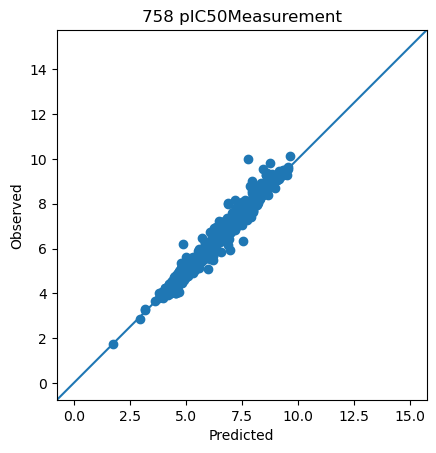

##### test

 MAE: 0.1798±0.0097 95CI=(0.1662, 0.1979)
 MSE: 0.0667±0.0148 95CI=(0.0490, 0.0935)
  R2: 0.9645±0.0079 95CI=(0.9493, 0.9742)
RMSE: 0.2568±0.0279 95CI=(0.2213, 0.3058)


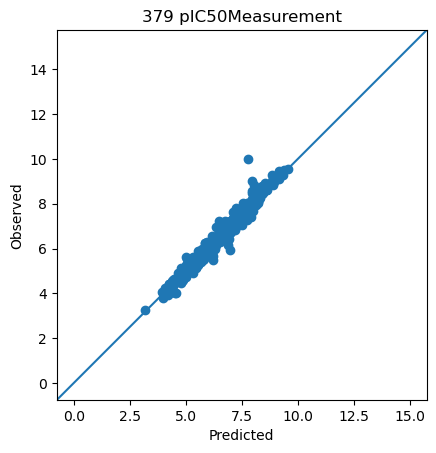

##### val

 MAE: 0.1862±0.0108 95CI=(0.1705, 0.2051)
 MSE: 0.0773±0.0113 95CI=(0.0601, 0.0970)
  R2: 0.9629±0.0059 95CI=(0.9526, 0.9709)
RMSE: 0.2773±0.0202 95CI=(0.2452, 0.3114)


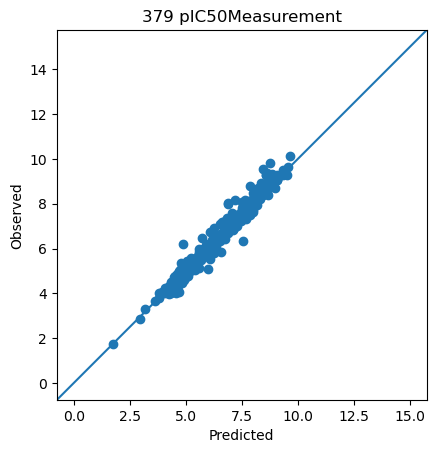

In [34]:
metrics = {}
nn_model.train(False)
for key, loader in dataloaders.items():
    metrics[key] = {}
    display(Markdown(f"#### {key}"))
    for ttype, dataloader in loader.items():
        display(Markdown(f"##### {ttype}"))
        try:
            mtype= import_object(f"kinoml.core.measurements.{key}")
        except AttributeError: 
            mtype = import_object(f"kinoml.core.measurements.{key.split('__')[1]}")
        obs_model = mtype.observation_model(backend="pytorch")
        x, y = dataloader.dataset[dataloader.batch_sampler.sampler.indices]
        prediction = obs_model(nn_model(x).view_as(y).detach().numpy())

        perf_data = performance(prediction, y, verbose=False)
        metrics[key][ttype] = {}
        for perfkey, values in perf_data.items():
            metrics[key][ttype][perfkey] = {"mean": values[0], "std": values[1]}
        display(predicted_vs_observed(prediction, y, mtype))

### Summary

`kinase_metrics` is a nested dictionary with these dimensions:

- measurement type
- metric
- mean & standard deviation

In [35]:
import json

display(Markdown(f"""
### Configuration 

```json
{json.dumps(_hparams, default=str, indent=2)}
```
"""))

if VERBOSE:
    display(Markdown(
f"""
### Kinase metrics

```json
{json.dumps(metrics, default=str, indent=2)}
```
"""))


### Configuration 

```json
{
  "VERSION": "2023.11.06",
  "HERE": "/home/raquellrdc/Desktop/postdoc/kinoml_tech_paper_final/kinoml/examples/experiments/ligand-only-smiles-EGFR",
  "DATASET_CLS": "kinoml.datasets.chembl.ChEMBLDatasetProvider",
  "DATASET_KWARGS": {
    "path_or_url": "../data/filtered_dataset_EGFR.csv",
    "sample": 1000
  },
  "PIPELINES": {
    "ligand": [
      [
        "kinoml.features.ligand.OneHotSMILESFeaturizer",
        {}
      ],
      [
        "kinoml.features.core.PadFeaturizer",
        {
          "shape": "auto"
        }
      ]
    ]
  },
  "PIPELINES_AGG": "kinoml.features.core.TupleOfArrays",
  "PIPELINES_AGG_KWARGS": {},
  "FEATURIZE_KWARGS": {
    "keep": false
  },
  "GROUPS": [
    [
      "kinoml.datasets.groups.CallableGrouper",
      {
        "function": "<function <lambda> at 0x7f4dc22ff9d0>"
      }
    ],
    [
      "kinoml.datasets.groups.CallableGrouper",
      {
        "function": "<function <lambda> at 0x7f4dc22ff430>"
      }
    ]
  ],
  "TRAIN_TEST_VAL_KWARGS": {
    "idx_train": 0.8,
    "idx_test": 0.1,
    "idx_val": 0.1
  },
  "REPO": "/home/raquellrdc/Desktop/postdoc/kinoml_tech_paper_final/kinoml",
  "OUT": "/home/raquellrdc/Desktop/postdoc/kinoml_tech_paper_final/kinoml/examples/experiments/ligand-only-smiles-EGFR/_output/20231106-101546",
  "X": "[[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0], ...], ...]]",
  "PARQUET_LOADER_CLS": "kinoml.datasets.torch_datasets.AwkwardArrayDataset",
  "PARQUET_FILES": [
    "ligand-only-smiles-EGFR/_output/ligand__OneHotSMILESFeaturizer__PadFeaturizer_shape=auto/ChEMBLDatasetProvider/*.parquet"
  ],
  "MODEL_CLS": "kinoml.ml.torch_models.ConvolutionNeuralNetworkRegression",
  "MODEL_KWARGS": {
    "hidden_shape": 350,
    "input_shape": [
      53,
      159
    ]
  },
  "OPTIMIZER": "torch.optim.Adam",
  "OPTIMIZER_KWARGS": {
    "lr": 0.001,
    "eps": 1e-07,
    "betas": [
      0.9,
      0.999
    ]
  },
  "LOSS": "torch.nn.MSELoss",
  "LOSS_KWARGS": {},
  "MAX_EPOCHS": 50,
  "VALIDATION": true,
  "EARLY_STOPPING_KWARGS": {},
  "DATALOADER_CLS": "torch.utils.data.DataLoader",
  "BATCH_SIZE": 64,
  "TRAIN_TEST_SPLIT": 0.2,
  "SHUFFLE_SPLITS": true,
  "COLLATE_FN": null,
  "N_BOOTSTRAPS": 1,
  "BOOTSTRAP_SAMPLE_RATIO": 1,
  "VERBOSE": false,
  "FEATURES_STORE": "/home/raquellrdc/Desktop/postdoc/kinoml_tech_paper_final/kinoml/examples/experiments"
}
```


In [36]:
for mtype_name in MEASUREMENT_TYPES:
    mtype_metrics = metrics.get(mtype_name)
    if not mtype_metrics:
        continue
        
    display(Markdown(f"#### {mtype_name}"))
    
    # flatten dict a bit: from dict["test"]["r2"]["mean"] to dict["test"]["r2_mean"]
    flattened = {}
    for ttype, scores in mtype_metrics.items():
        flattened[ttype] = {}
        for score, stats in scores.items():
            for stat, value in stats.items():
                flattened[ttype][f"{score}_{stat}"] = value
        
    df = pd.DataFrame.from_dict(flattened, orient="index")
    with pd.option_context("display.float_format", "{:.3f}".format, "display.max_rows", len(df)):
        display(
            df.style.background_gradient(subset=["r2_mean"], low=0, high=1, vmin=0, vmax=1)
              .apply(lambda x: ['font-weight: bold' for v in x], subset=["r2_mean"])
        )

#### P00533__pIC50Measurement

,mae_mean,mae_std,mse_mean,mse_std,r2_mean,r2_std,rmse_mean,rmse_std
train,0.183260,0.007219,0.072225,0.009288,0.963449,0.004629,0.268209,0.016991
test,0.179782,0.009711,0.066738,0.014805,0.964520,0.007867,0.256827,0.027890
val,0.186170,0.010785,0.077324,0.011253,0.962918,0.005942,0.277336,0.020215


#### P00533__pKdMeasurement

,mae_mean,mae_std,mse_mean,mse_std,r2_mean,r2_std,rmse_mean,rmse_std
train,0.344678,0.128756,0.307806,0.255294,0.751761,0.248068,0.504852,0.230067
test,0.246742,0.070413,0.087939,0.046978,0.726874,0.979202,0.285983,0.078438
val,0.452279,0.247003,0.540277,0.509896,-53.957348,538.856945,0.636427,0.367746


#### P00533__pKiMeasurement

,mae_mean,mae_std,mse_mean,mse_std,r2_mean,r2_std,rmse_mean,rmse_std
train,0.160410,0.019357,0.035080,0.007079,0.975931,0.014664,0.186349,0.018824
test,0.182744,0.027550,0.042085,0.011447,0.965866,0.040565,0.203163,0.028461
val,0.133422,0.030496,0.026664,0.010667,0.969537,0.028914,0.159950,0.032868


In [37]:
print("Run finished at", datetime.now())

Run finished at 2023-11-06 10:17:11.790579


### Save reports to disk

In [38]:
from kinoml.utils import watermark
w = watermark()

Watermark
---------
Last updated: 2023-11-06T10:17:11.796459+01:00

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.15.0

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 6.2.0-36-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 16
Architecture: 64bit

Hostname: aleph

Git hash: d2352d6e07d594ed9fd973b544529f89feb82d78

torch  : 2.1.0
sys    : 3.9.18 | packaged by conda-forge | (main, Aug 30 2023, 03:49:32) 
[GCC 12.3.0]
json   : 2.0.9
pandas : 2.1.1
numpy  : 1.26.0
kinoml : 0+unknown
awkward: 2.4.6

Watermark: 2.4.3


nvidia-smi
----------
stdout:
Mon Nov  6 10:17:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/C

In [39]:
%%capture cap --no-stderr
w = watermark()

In [40]:
import json

with open(OUT / "performance.json", "w") as f:
    json.dump(metrics, f, default=str, indent=2)
    
with open(OUT/ "watermark.txt", "w") as f:
    f.write(cap.stdout)

with open(OUT / "hparams.json", "w") as f:
    json.dump(_hparams, f, default=str, indent=2)

And this is it! We have run an experiment end to end, from obtaining the data to evaluating and saving the model!